In [1]:
"""
This example does neural network regression against a parabola using the same neural network setup as FitSNAP.
"""

'\nThis example is the same as the previous nn_quadratic_d1, except here we use nn.Sequential \nand a different neural network setup (which is similar to FitSNAP).\n'

In [1]:
%matplotlib inline

import numpy as np

from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import tensor

/Users/adrohsk/venv-3.10-brew2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([30, 1])
torch.Size([30])


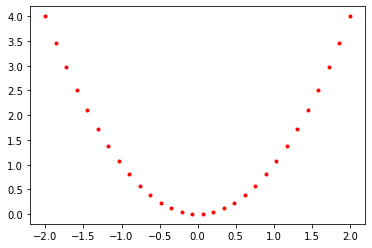

In [2]:
# Make fitting data.
X = torch.linspace(-2., 2., 30).unsqueeze(1)
print(X.shape)
#Y = torch.cat([torch.zeros(10),  torch.linspace(0., 1., 10), 1. + torch.zeros(10)], dim=0)
Y = torch.square(X).flatten()
targets = Y
print(Y.shape)
plt.plot(X.squeeze().numpy(), Y.numpy(), 'r.')

In [3]:
print(X)

tensor([[-2.0000],
        [-1.8621],
        [-1.7241],
        [-1.5862],
        [-1.4483],
        [-1.3103],
        [-1.1724],
        [-1.0345],
        [-0.8966],
        [-0.7586],
        [-0.6207],
        [-0.4828],
        [-0.3448],
        [-0.2069],
        [-0.0690],
        [ 0.0690],
        [ 0.2069],
        [ 0.3448],
        [ 0.4828],
        [ 0.6207],
        [ 0.7586],
        [ 0.8966],
        [ 1.0345],
        [ 1.1724],
        [ 1.3103],
        [ 1.4483],
        [ 1.5862],
        [ 1.7241],
        [ 1.8621],
        [ 2.0000]])


In [30]:
"""
Define the network parameters.
"""
#layer_sizes = ['num_desc', '10', '8', '6', '1'] # FitSNAP style
#layer_sizes = [1, 10, 1]
layer_sizes = [1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1]

In [31]:
"""
Create our neural network.
"""
def create_torch_network(layer_sizes):
    """
    Creates a pytorch network architecture from layer sizes.
    This also performs standarization in the first linear layer.
    ADR: No I don't think it standardizes anything...
    This only supports softplus as the nonlinear activation function.

        Parameters:
            layer_sizes (list of ints): Size of each network layers

        Return:
            Network Architecture of type neural network sequential

    """
    layers = []
    try:
        layers.append(torch.nn.Linear(layer_sizes[0], layer_sizes[0]))
        for i, layer in enumerate(layer_sizes):
            layers.append(torch.nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            layers.append(torch.nn.Softplus())
    except IndexError:
        layers.pop()
    return torch.nn.Sequential(*layers)

network_architecture = create_torch_network(layer_sizes)
print(network_architecture)
#print(type(network_architecture))
for name, param in network_architecture.named_parameters():
    print("------")
    print(name)
    print(param)

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): Linear(in_features=1, out_features=2500, bias=True)
  (2): Softplus(beta=1, threshold=20)
  (3): Linear(in_features=2500, out_features=2500, bias=True)
  (4): Softplus(beta=1, threshold=20)
  (5): Linear(in_features=2500, out_features=1, bias=True)
)
------
0.weight
Parameter containing:
tensor([[0.5539]], requires_grad=True)
------
0.bias
Parameter containing:
tensor([0.4600], requires_grad=True)
------
1.weight
Parameter containing:
tensor([[ 0.0687],
        [-0.8191],
        [ 0.0537],
        ...,
        [ 0.1882],
        [ 0.7599],
        [ 0.6812]], requires_grad=True)
------
1.bias
Parameter containing:
tensor([ 0.8736,  0.2200,  0.5445,  ..., -0.7148,  0.4597,  0.4008],
       requires_grad=True)
------
3.weight
Parameter containing:
tensor([[-0.0089, -0.0093, -0.0055,  ...,  0.0173,  0.0191, -0.0136],
        [ 0.0081, -0.0042, -0.0030,  ...,  0.0017, -0.0037,  0.0008],
        [ 0.0029, -0.0069,  

In [32]:
"""
Define the model
"""
class FitTorch(torch.nn.Module):
    """
    FitSNAP PyTorch Neural Network Architecture Model
    Currently only fits on energies
    """

    def __init__(self, network_architecture, descriptor_count, n_elements=1):
        """
        Saves lammps ready pytorch model.

            Parameters:
                network_architecture : A nn.Sequential network architecture
                descriptor_count (int): Length of descriptors for an atom
                n_elements (int): Number of differentiable atoms types

        """
        super().__init__()
        self.network_architecture = network_architecture
        self.desc_len = descriptor_count
        self.n_elem = n_elements
        
    def forward(self, x, indices, atoms_per_structure):
        """
        Saves lammps ready pytorch model.

            Parameters:
                x (tensor of floats): Array of descriptors
                indices (tensor of ints): Array of indices upon which to contract per atom energies
                atoms_per_structure (tensor of ints): Number of atoms per configuration

        """

        predicted_energy_total = torch.zeros(atoms_per_structure.size())
        #print(self.network_architecture(x))
        predicted_energy_total.index_add_(0, indices, self.network_architecture(x).squeeze())
        return predicted_energy_total

    def import_wb(self, weights, bias):
        """
        Imports weights and bias into FitTorch model

            Parameters:
                weights (list of numpy array of floats): Network weights at each layer
                bias (list of numpy array of floats): Network bias at each layer

        """

        assert len(weights) == len(bias)
        imported_parameter_count = sum(w.size + b.size for w, b in zip(weights, bias))
        combined = [None] * (len(weights) + len(bias))
        combined[::2] = weights
        combined[1::2] = bias

        assert len([p for p in self.network_architecture.parameters()]) == len(combined)
        assert sum(p.nelement() for p in self.network_architecture.parameters()) == imported_parameter_count

        state_dict = self.state_dict()
        for i, key in enumerate(state_dict.keys()):
            state_dict[key] = torch.tensor(combined[i])
        self.load_state_dict(state_dict)

In [33]:
"""
Create the model.
"""
nd = 1
model = FitTorch(network_architecture, 1)
print(model)
#print(model.network_architecture,0,weight)

FitTorch(
  (network_architecture): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): Linear(in_features=1, out_features=2500, bias=True)
    (2): Softplus(beta=1, threshold=20)
    (3): Linear(in_features=2500, out_features=2500, bias=True)
    (4): Softplus(beta=1, threshold=20)
    (5): Linear(in_features=2500, out_features=1, bias=True)
  )
)


In [36]:
nconfigs = 30
num_atoms = torch.ones(nconfigs,dtype=torch.int32) # number of atoms per config
descriptors = X
indices = np.linspace(0,nconfigs-1,30).astype(int)
indices = torch.from_numpy(indices)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model.parameters)
print(indices)
#print(descriptors)
#print(indices)
#print(type(num_atoms))
test = model(descriptors, indices, num_atoms)
print(test)
energies = torch.reshape(model(descriptors, indices, num_atoms), (-1,)).to(device)
print(energies)

<bound method Module.parameters of FitTorch(
  (network_architecture): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): Linear(in_features=1, out_features=2500, bias=True)
    (2): Softplus(beta=1, threshold=20)
    (3): Linear(in_features=2500, out_features=2500, bias=True)
    (4): Softplus(beta=1, threshold=20)
    (5): Linear(in_features=2500, out_features=1, bias=True)
  )
)>
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
tensor([0.2033, 0.2034, 0.2036, 0.2038, 0.2040, 0.2043, 0.2046, 0.2050, 0.2054,
        0.2058, 0.2063, 0.2068, 0.2073, 0.2079, 0.2085, 0.2091, 0.2098, 0.2105,
        0.2112, 0.2120, 0.2128, 0.2137, 0.2147, 0.2156, 0.2167, 0.2178, 0.2190,
        0.2202, 0.2215, 0.2228], grad_fn=<IndexAddBackward1>)
tensor([0.2033, 0.2034, 0.2036, 0.2038, 0.2040, 0.2043, 0.2046, 0.2050, 0.2054,
        0.2058, 0.2063, 0.2068, 0.2073, 0.2079, 0.2085, 0.2091, 0.2

In [37]:
"""
Train
"""
for epoch in range(100000):
    #print(epoch)
    energies = torch.reshape(model(descriptors, indices, num_atoms), (-1,)).to(device)
    loss = loss_function(energies/num_atoms, targets)
    if (epoch % 100 == 1):
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

epoch: 2, loss = 3.0926
epoch: 102, loss = 613298496.0000
epoch: 202, loss = 1885649.3750
epoch: 302, loss = 3.6691
epoch: 402, loss = 3.8146
epoch: 502, loss = 3.9414
epoch: 602, loss = 4.0536
epoch: 702, loss = 4.1537
epoch: 802, loss = 4.2436
epoch: 902, loss = 4.3248
epoch: 1002, loss = 4.3982
epoch: 1102, loss = 4.4648
epoch: 1202, loss = 4.5254
epoch: 1302, loss = 4.5806
epoch: 1402, loss = 4.6308
epoch: 1502, loss = 4.6767
epoch: 1602, loss = 4.7185
epoch: 1702, loss = 4.7567
epoch: 1802, loss = 4.7915
epoch: 1902, loss = 4.8234
epoch: 2002, loss = 4.8524
epoch: 2102, loss = 4.8790
epoch: 2202, loss = 4.9033
epoch: 2302, loss = 4.9254
epoch: 2402, loss = 4.9456
epoch: 2502, loss = 4.9641
epoch: 2602, loss = 4.9809
epoch: 2702, loss = 4.9963


KeyboardInterrupt: 

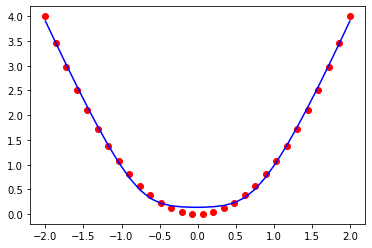

In [29]:
# Plot
predicted = model(descriptors,indices,num_atoms).detach().numpy()

plt.plot(X.numpy(), Y.numpy(), 'ro')
plt.plot(X.numpy(), predicted, 'b')
plt.show()